In [ ]:
import sys
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


In [ ]:
df=pd.read_csv('/content/all_tickets.csv')
dfTickets=df.copy()

In [ ]:
df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [ ]:
dfTickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             47837 non-null  object
 1   body              48549 non-null  object
 2   ticket_type       48549 non-null  int64 
 3   category          48549 non-null  int64 
 4   sub_category1     48549 non-null  int64 
 5   sub_category2     48549 non-null  int64 
 6   business_service  48549 non-null  int64 
 7   urgency           48549 non-null  int64 
 8   impact            48549 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 3.3+ MB


In [ ]:
dfTickets.isnull().sum()

title               712
body                  0
ticket_type           0
category              0
sub_category1         0
sub_category2         0
business_service      0
urgency               0
impact                0
dtype: int64

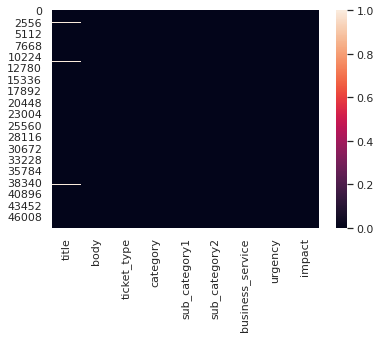

In [ ]:
sns.heatmap(dfTickets.isnull())

In [ ]:
dfTickets.columns

Index(['title', 'body', 'ticket_type', 'category', 'sub_category1',
       'sub_category2', 'business_service', 'urgency', 'impact'],
      dtype='object')

# **Count Plots**

In [ ]:
def countplot(string):
   return sns.histplot(x =string, data = dfTickets)

32    8174
36    3685
68    3589
67    2858
4     2527
      ... 
37       1
69       1
81       1
17       1
0        1
Name: business_service, Length: 103, dtype: int64

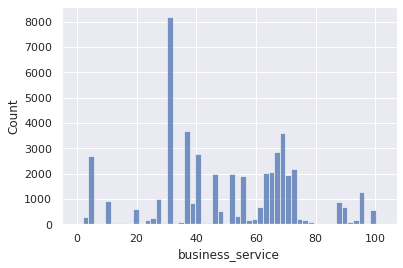

In [ ]:
countplot('business_service')
dfTickets['business_service'].value_counts()

1    34621
0    13928
Name: ticket_type, dtype: int64

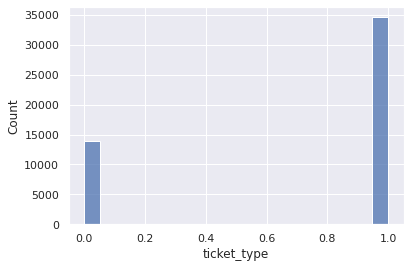

In [ ]:
countplot('ticket_type')
dfTickets['ticket_type'].value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

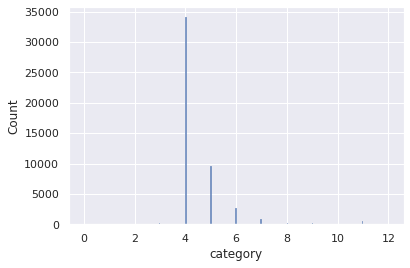

In [ ]:
countplot('category')
dfTickets['category'].value_counts()

2     9857
3     8324
1     7857
13    6487
21    5710
51    2402
22    1475
15    1226
9     1114
12     624
14     620
32     559
39     354
30     222
54     217
50     204
36     177
45     176
56     147
10     114
35      83
27      79
28      60
49      57
41      54
37      48
16      42
58      34
17      27
53      26
57      25
8       15
55      13
24      12
34      11
33      10
19       8
44       8
4        7
43       7
26       6
20       6
18       6
38       5
40       4
52       4
0        4
31       3
6        3
42       3
7        2
48       2
23       2
46       2
5        1
11       1
47       1
25       1
29       1
Name: sub_category1, dtype: int64

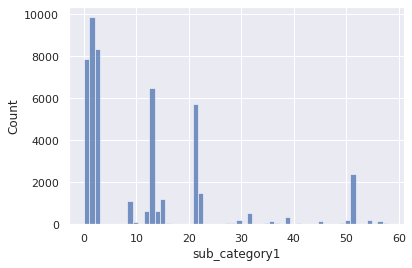

In [ ]:
countplot('sub_category1')
dfTickets['sub_category1'].value_counts()

7      18197
21      6581
41      3232
0       2705
88      2243
       ...  
72         1
79         1
39         1
102        1
24         1
Name: sub_category2, Length: 115, dtype: int64

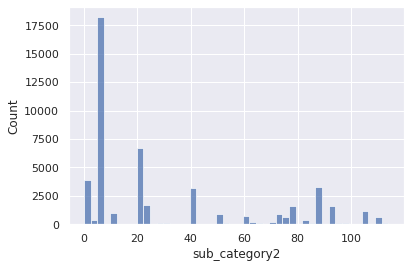

In [ ]:
countplot('sub_category2')
dfTickets['sub_category2'].value_counts()

3    34621
1     6748
2     5528
0     1652
Name: urgency, dtype: int64

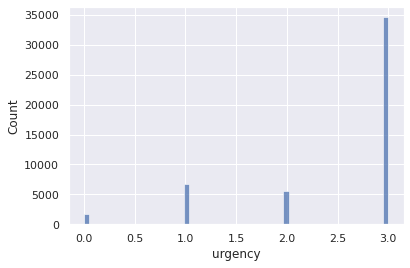

In [ ]:
countplot('urgency')
dfTickets['urgency'].value_counts()

4    34621
3    13184
0      471
2      228
1       45
Name: impact, dtype: int64

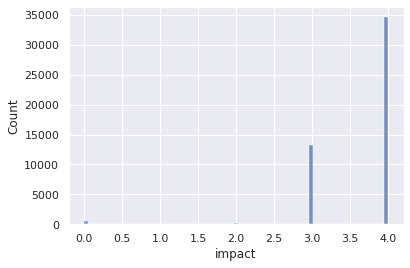

In [ ]:
countplot('impact')
dfTickets['impact'].value_counts()

# **Predicting Ticket_type**

In [ ]:
bytag = dfTickets.groupby('ticket_type').aggregate(np.count_nonzero)
bytag


,title,body,category,sub_category1,sub_category2,business_service,urgency,impact
ticket_type,,,,,,,,
0,13928,13928,13928,13928,12868,13927,12276,13457
1,34621,34621,34617,34617,32976,34621,34621,34621


In [ ]:
tags = bytag[bytag.body > 1].index
(tags)

Int64Index([0, 1], dtype='int64', name='ticket_type')

In [ ]:
dfTickets = dfTickets[dfTickets['ticket_type'].isin(tags)]
dfTickets.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


## Prepare data and labels and split them to train and test sets

In [ ]:
label=dfTickets['ticket_type']
data=dfTickets['body']
print('label shape size',label.shape)
print('data shape size',data.shape)


label shape size (48549,)
data shape size (48549,)


In [ ]:
# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.2,random_state=42)  # split data to train/test sets with 80:20 ratio

## Extracting features from text

In [ ]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
count_vect = StemmedCountVectorizer(stop_words='english')

vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(38839, 6442)

In [ ]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(38839, 6442)

## Using pipeline to preprocess data and train classifier

In [ ]:
text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(fit_prior=False)) ])
text_clf = text_clf.fit(train_data, train_labels)

### **Use GridSearchCV to search for best set of parameters**

In [ ]:
# parameters = {
#         'vect__ngram_range': [(1, 1), (1, 2)],
#         'tfidf__use_idf': (True, False),
#         'clf__alpha': (1e-2, 1e-3)}

# gs_clf = GridSearchCV(text_clf  , parameters, n_jobs=-1)
# gs_clf = gs_clf.fit(train_data, train_labels)

# print(gs_clf.best_score_)
# print(gs_clf.best_params_)


In [ ]:
# print(gs_clf.best_score_)
# print(gs_clf.best_params_)

## Evaluate the model

**Score and evaluate model on test data using model without hyperparameter tuning**

In [ ]:
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

Confusion matrix without GridSearch:
[[2701   79]
 [ 543 6387]]
Mean without GridSearch: 0.9359423274974253


**Score and evaluate model on test data using model WITH hyperparameter tuning**

In [ ]:
# predicted = gs_clf.predict(test_data)
# prediction_acc = np.mean(predicted == test_labels)
# print("Confusion matrix with GridSearch:")
# print(metrics.confusion_matrix(test_labels, predicted))
# print("Mean with GridSearch: " + str(prediction_acc))

# **Ploting confusion matrix**

Text(15.380000000000003, 0.5, 'predicted label')

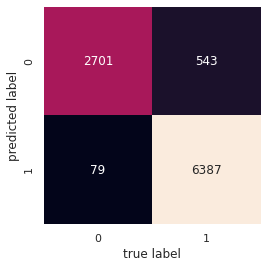

In [ ]:
mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

## Printing classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2780
           1       0.99      0.92      0.95      6930

    accuracy                           0.94      9710
   macro avg       0.91      0.95      0.93      9710
weighted avg       0.94      0.94      0.94      9710



# **Predicting Ticket_type without Stemming**

In [ ]:
bytag = dfTickets.groupby('ticket_type').aggregate(np.count_nonzero)
bytag


,title,body,category,sub_category1,sub_category2,business_service,urgency,impact
ticket_type,,,,,,,,
0,12847,12847,12847,12847,12144,12846,11331,12589
1,34405,34405,34405,34405,32825,34405,34405,34405


In [ ]:
tags = bytag[bytag.body > 1].index
(tags)

Int64Index([0, 1], dtype='int64', name='ticket_type')

In [ ]:
dfTickets = dfTickets[dfTickets['ticket_type'].isin(tags)]
dfTickets.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


## Prepare data and labels and split them to train and test sets

In [ ]:
label=dfTickets['ticket_type']
data=dfTickets['body']
print('label shape size',label.shape)
print('data shape size',data.shape)


label shape size (47252,)
data shape size (47252,)


In [ ]:
# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.2,random_state=42)  # split data to train/test sets with 80:20 ratio

## Extracting features from text

In [ ]:
# class StemmedCountVectorizer(CountVectorizer):
#     def build_analyzer(self):
#         analyzer = super(StemmedCountVectorizer, self).build_analyzer()
#         stemmer = SnowballStemmer("english", ignore_stopwords=True)
#         return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# count_vect = StemmedCountVectorizer(stop_words='english')
count_vect = CountVectorizer(stop_words='english')
vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(37801, 11105)

In [ ]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(37801, 11105)

## Using pipeline to preprocess data and train classifier

In [ ]:
text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(fit_prior=False)) ])
text_clf = text_clf.fit(train_data, train_labels)

### **Use GridSearchCV to search for best set of parameters**

In [ ]:

# parameters = {
#         'vect__ngram_range': [(1, 1), (1, 2)],
#         'tfidf__use_idf': (True, False),
#         'clf__alpha': (1e-2, 1e-3)}

# gs_clf = GridSearchCV(text_clf  , parameters, n_jobs=-1)
# gs_clf = gs_clf.fit(train_data, train_labels)

# print(gs_clf.best_score_)
# print(gs_clf.best_params_)


In [ ]:
# print(gs_clf.best_score_)
# print(gs_clf.best_params_)

## Evaluate the model

**Score and evaluate model on test data using model without hyperparameter tuning**

In [ ]:
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

Confusion matrix without GridSearch:
[[2521   39]
 [ 324 6567]]


TypeError: ignored

**Score and evaluate model on test data using model WITH hyperparameter tuning**

In [ ]:
# predicted = gs_clf.predict(test_data)
# prediction_acc = np.mean(predicted == test_labels)
# print("Confusion matrix with GridSearch:")
# print(metrics.confusion_matrix(test_labels, predicted))
# print("Mean with GridSearch: " + str(prediction_acc))

# **Ploting confusion matrix**

Text(25.1, 0.5, 'predicted label')

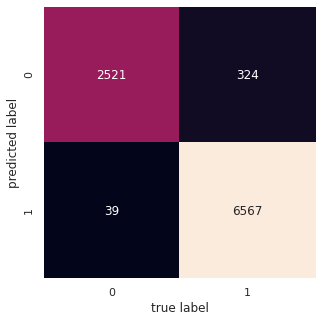

In [ ]:
mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(5, 5))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

## Printing classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2560
           1       0.99      0.95      0.97      6891

    accuracy                           0.96      9451
   macro avg       0.94      0.97      0.95      9451
weighted avg       0.96      0.96      0.96      9451



# **Predicting Category**

In [ ]:
min_data_per_class = 200
Predicting_label='category'

In [ ]:
bytag = dfTickets.groupby(Predicting_label).aggregate(np.count_nonzero)
bytag
# tags = bytag[bytag.body > min_data_per_class].index
# dfTickets = dfTickets[dfTickets[column_to_predict].isin(tags)]

,title,body,ticket_type,sub_category1,sub_category2,business_service,urgency,impact
category,,,,,,,,
0,4,4,4,0,0,4,4,4
1,72,72,47,72,38,72,71,71
2,3,3,0,3,1,3,2,3
3,137,137,37,137,41,137,137,137
4,34061,34061,24523,34061,32609,34061,32948,34000
5,9634,9634,7087,9634,9156,9634,9508,9613
6,2628,2628,1774,2628,2306,2628,2258,2603
7,921,921,921,921,900,921,921,921
8,239,239,56,239,199,238,237,239


In [ ]:
tags = bytag[bytag.body > min_data_per_class].index
(tags)

Int64Index([4, 5, 6, 7, 8, 11], dtype='int64', name='category')

In [ ]:
dfTickets = dfTickets[dfTickets[Predicting_label].isin(tags)]
dfTickets.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [ ]:
label=dfTickets[Predicting_label]
data=dfTickets['body']
print('label shape size',label.shape)
print('data shape size',data.shape)


label shape size (48095,)
data shape size (48095,)


In [ ]:
# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.2,random_state=42)  # split data to train/test sets with 80:20 ratio

## Extracting features from text

In [ ]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
count_vect = StemmedCountVectorizer(stop_words='english')

vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(38476, 6410)

In [ ]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(38476, 6410)

## Using pipeline to preprocess data and train classifier

In [ ]:
text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(fit_prior=False)) ])
text_clf = text_clf.fit(train_data, train_labels)

### **Use GridSearchCV to search for best set of parameters**

In [ ]:
# parameters = {
#         'vect__ngram_range': [(1, 1), (1, 2)],
#         'tfidf__use_idf': (True, False),
#         'clf__alpha': (1e-2, 1e-3)}

# gs_clf = GridSearchCV(text_clf  , parameters, n_jobs=-1)
# gs_clf = gs_clf.fit(train_data, train_labels)

# print(gs_clf.best_score_)
# print(gs_clf.best_params_)


In [ ]:
# print(gs_clf.best_score_)
# print(gs_clf.best_params_)

## Evaluate the model

**Score and evaluate model on test data using model without hyperparameter tuning**

In [ ]:
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

Confusion matrix without GridSearch:
[[6107  303  287   94    4   20]
 [ 390 1441   96   28    0    2]
 [ 166   73  235    8    0    4]
 [  75    9    2   89    0    3]
 [   6    1   16    0   36    0]
 [  35    4    8   15    0   62]]
Mean without GridSearch: 0.8285684582596944


**Score and evaluate model on test data using model WITH hyperparameter tuning**

In [ ]:
# predicted = gs_clf.predict(test_data)
# prediction_acc = np.mean(predicted == test_labels)
# print("Confusion matrix with GridSearch:")
# print(metrics.confusion_matrix(test_labels, predicted))
# print("Mean with GridSearch: " + str(prediction_acc))

# **Ploting confusion matrix**

Text(15.380000000000003, 0.5, 'predicted label')

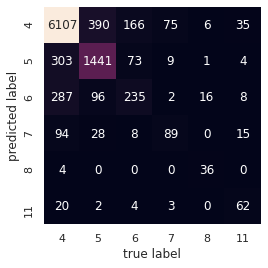

In [ ]:
mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
%matplotlib inline
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

           4       0.90      0.90      0.90      6815
           5       0.79      0.74      0.76      1957
           6       0.36      0.48      0.42       486
           7       0.38      0.50      0.43       178
           8       0.90      0.61      0.73        59
          11       0.68      0.50      0.58       124

    accuracy                           0.83      9619
   macro avg       0.67      0.62      0.64      9619
weighted avg       0.84      0.83      0.83      9619



# **Predicting sub_category1**

In [ ]:
min_data_per_class = 200
Predicting_label='sub_category1'

In [ ]:
bytag = dfTickets.groupby(Predicting_label).aggregate(np.count_nonzero)
bytag


,title,body,ticket_type,category,sub_category2,business_service,urgency,impact
sub_category1,,,,,,,,
0,4,4,4,0,0,4,4,4
1,7857,7857,7857,7857,7605,7857,7857,7857
2,9857,9857,9857,9857,9575,9857,9857,9857
3,8324,8324,8324,8324,7772,8324,8324,8324
4,7,7,1,7,5,7,6,6
5,1,1,1,1,1,1,1,1
6,3,3,3,3,2,3,3,3
7,2,2,0,2,1,2,1,2
8,15,15,5,15,0,15,15,15


In [ ]:
tags = bytag[bytag.body > min_data_per_class].index
(tags)

Int64Index([1, 2, 3, 9, 12, 13, 14, 15, 21, 22, 30, 32, 39, 50, 51, 54], dtype='int64', name='sub_category1')

In [ ]:
dfTickets = dfTickets[dfTickets[Predicting_label].isin(tags)]
dfTickets.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [ ]:
label=dfTickets[Predicting_label]
data=dfTickets['body']
print('label shape size',label.shape)
print('data shape size',data.shape)


label shape size (47252,)
data shape size (47252,)


In [ ]:
# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.2,random_state=42)  # split data to train/test sets with 80:20 ratio

## Extracting features from text

In [ ]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
count_vect = StemmedCountVectorizer(stop_words='english')

vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(37801, 6274)

In [ ]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(37801, 6274)

## Using pipeline to preprocess data and train classifier

In [ ]:
text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(fit_prior=False)) ])
text_clf = text_clf.fit(train_data, train_labels)

### **Use GridSearchCV to search for best set of parameters**

In [ ]:
# parameters = {
#         'vect__ngram_range': [(1, 1), (1, 2)],
#         'tfidf__use_idf': (True, False),
#         'clf__alpha': (1e-2, 1e-3)}

# gs_clf = GridSearchCV(text_clf  , parameters, n_jobs=-1)
# gs_clf = gs_clf.fit(train_data, train_labels)

# print(gs_clf.best_score_)
# print(gs_clf.best_params_)


In [ ]:
# print(gs_clf.best_score_)
# print(gs_clf.best_params_)

## Evaluate the model

**Score and evaluate model on test data using model without hyperparameter tuning**

In [ ]:
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

Confusion matrix without GridSearch:
[[ 921  352  224    1    0   29    0   21   35   25    0    6    2    0
     7    0]
 [ 321 1113  350    1    0   39    0   13   81   14    0    3    0    1
    18    0]
 [ 230  429  793    2    1   36    1   38   81   48    0    3    0    1
     2    0]
 [   2    5    5    2    0    7    0    0  180    0    0    1    0    0
    17    0]
 [   0    0    3    0    3    5    6    4   90    0    1    0    0    0
    12    0]
 [  45   89   51    0    1  987    8   24   53   16    0    5    5    2
     7    0]
 [   0    1    2    0    1    8   48    3   56    0    0    0    0    0
     8    0]
 [  26   15   49    0    0   23    7   94    2   12    0    1    0    0
     3    0]
 [  13   13   18    5    1   12    0    1 1004    2    0    1    1    1
    70    0]
 [  51   24   73    0    0   20    1    2    6  116    1    1    0    0
     0    0]
 [   0    0    6    0    0    0    0    0    2    1   32    0    0    0
     0    1]
 [   0    2    0    0    0  

TypeError: ignored

**Score and evaluate model on test data using model WITH hyperparameter tuning**

In [ ]:
# predicted = gs_clf.predict(test_data)
# prediction_acc = np.mean(predicted == test_labels)
# print("Confusion matrix with GridSearch:")
# print(metrics.confusion_matrix(test_labels, predicted))
# print("Mean with GridSearch: " + str(prediction_acc))

# **Ploting confusion matrix**

Text(54.260000000000005, 0.5, 'predicted label')

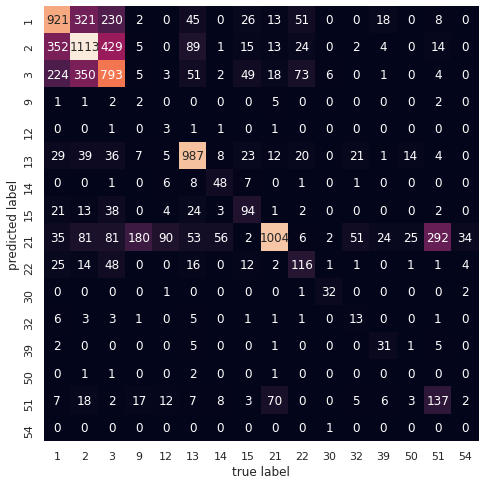

In [ ]:
mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(8, 8))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
%matplotlib inline
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

           1       0.56      0.57      0.57      1623
           2       0.54      0.57      0.55      1954
           3       0.50      0.48      0.49      1665
           9       0.15      0.01      0.02       219
          12       0.43      0.02      0.05       124
          13       0.82      0.76      0.79      1293
          14       0.67      0.38      0.48       127
          15       0.47      0.41      0.43       232
          21       0.50      0.88      0.64      1142
          22       0.48      0.39      0.43       295
          30       0.89      0.76      0.82        42
          32       0.37      0.14      0.20        94
          39       0.69      0.36      0.48        85
          50       0.00      0.00      0.00        44
          51       0.46      0.29      0.36       470
          54       0.00      0.00      0.00        42

    accuracy                           0.56      9451
   macro avg       0.47   